## 3. Simple FCN

### 3.1. 환경 세팅

In [25]:
!pip install torchsummary

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/vision/stable/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as dset

# https://pytorch.org/vision/stable/transforms.html
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다.
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# 기본 라이브러리
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 영상처리 관련 라이브러리 불러오기
import skimage
from skimage import io as skio
from skimage import transform as skit
from skimage import morphology as skim

print(torch.__version__)

2.1.0+cu121


### 3.2. 데이터셋

#### 3.2.1. 데이터셋 다운로드

* Dataset Download
  - reference link: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

In [27]:
# 데이터셋을 이 세션으로 불러오기
!git clone https://github.com/Pulsar-kkaturi/DL-Education.git

Cloning into 'DL-Education'...
remote: Enumerating objects: 969, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 969 (delta 214), reused 279 (delta 199), pack-reused 663
Receiving objects: 100% (969/969), 293.65 MiB | 25.20 MiB/s, done.
Resolving deltas: 100% (532/532), done.
Updating files: 100% (248/248), done.


In [28]:
# 압축 풀기
!tar -zxf ./DL-Education/dataset/brain_seg_2d.tar.gz

#### 3.2.2. 데이터셋 불러오기

In [29]:
img_fol_path = './brain_seg_2d/images'
msk_fol_path = './brain_seg_2d/masks'
img_file_list = [f for f in sorted(os.listdir(img_fol_path))]
msk_file_list = [f for f in sorted(os.listdir(msk_fol_path))]
# print(img_file_list)
# print(msk_file_list)

img_list, msk_list = [], []
for i, i_ in enumerate(img_file_list):
  img_path = os.path.join(img_fol_path, i_)
  msk_path = os.path.join(msk_fol_path, msk_file_list[i])
  img_arr = skio.imread(img_path)
  msk_arr = skio.imread(msk_path)
  img_list.append(img_arr)
  msk_list.append(msk_arr)

print('Image numbers = ', len(img_list))
print('Mask numbers = ', len(msk_list))

Image numbers =  1000
Mask numbers =  1000


* 이미지 정보 & 마스크 정보 확인

In [30]:
# 이미지 정보
print('이미지 크기 = ', img_list[0].shape)
print(f'이미지 최대값/최소값 = {np.max(img_list[0])}/{np.min(img_list[0])}')
# 마스크 정보
print('마스크 크기 = ', msk_list[0].shape)
print(f'마스크 최대값/최소값 = {np.max(msk_list[0])}/{np.min(msk_list[0])}')

이미지 크기 =  (512, 512)
이미지 최대값/최소값 = 255/0
마스크 크기 =  (512, 512)
마스크 최대값/최소값 = 255/0


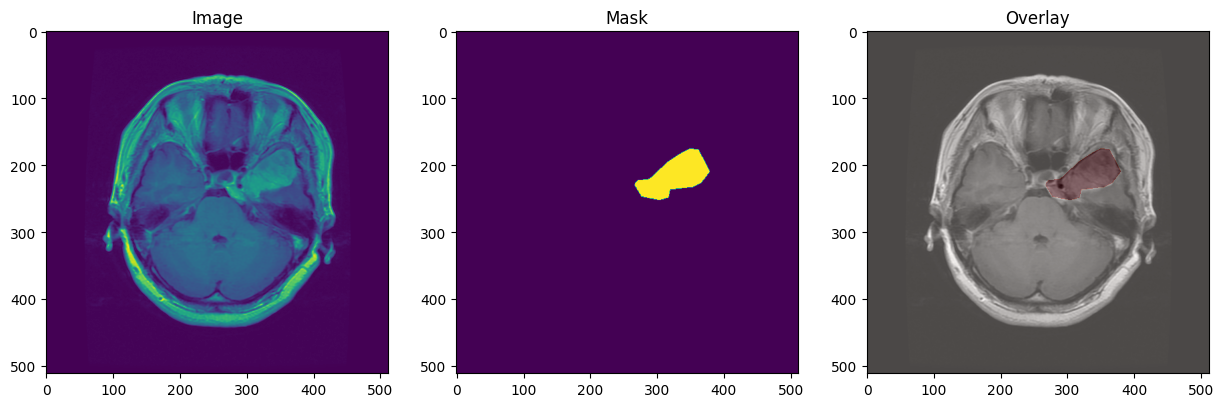

In [31]:
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(img_list[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(msk_list[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(img_list[0], cmap='gray')
plt.imshow(msk_list[0], cmap='Reds', alpha=0.3)

#### 3.2.3. 데이터셋 전처리

* Original Mask

In [32]:
img_size = (200, 200) # 이미지 사이즈 정규화
num_classes = 1 # 레이블 종류 (tumor 1개)

# 이미지 전처리
resized_imgs = [skit.resize(img, img_size, anti_aliasing=True) for img in img_list] # 이미지 크기 리사이징
img_arrays = np.expand_dims(np.array(resized_imgs, dtype=np.float32), axis=-1) # 이미지를 array로 변환
input_imgs = (img_arrays - np.min(img_arrays))/(np.max(img_arrays)-np.min(img_arrays)) # 이미지 정규화 (0~1)

# 마스크 전처리
resized_msks = [skit.resize(msk, img_size) for msk in msk_list] # 이미지 크기 리사이징
msk_arrays = np.expand_dims(np.array(resized_msks), axis=-1) # 마스크를 array로 변환
targets = np.where(msk_arrays > 0, 1, 0) # 레이블 형태(0,1)로 변환
targets = targets.astype(np.uint8)

# 이미지 정보
print('입력 어레이 크기 = ', input_imgs.shape)
print(f'입력 어레이 최대값/최소값 = {np.max(input_imgs)}/{np.min(input_imgs)}')
# 마스크 정보
print('타겟 어레이 크기 = ', targets.shape)
print(f'타켓 어레이 최대값/최소값 = {np.max(targets)}/{np.min(targets)}')

입력 어레이 크기 =  (1000, 200, 200, 1)
입력 어레이 최대값/최소값 = 1.0/0.0
타겟 어레이 크기 =  (1000, 200, 200, 1)
타켓 어레이 최대값/최소값 = 1/0


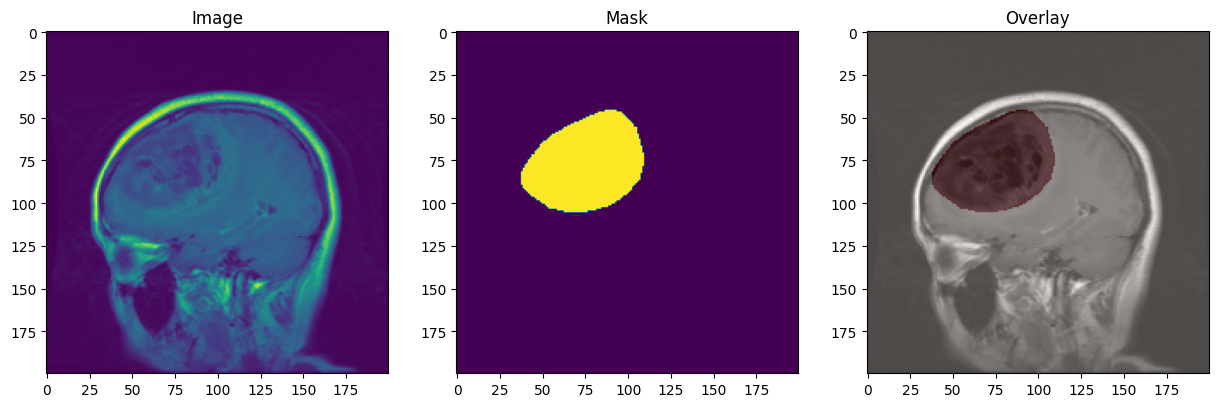

In [33]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# 검증 데이터셋 확인
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(val_input_imgs[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(val_targets[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(val_input_imgs[0], cmap='gray')
plt.imshow(val_targets[0], cmap='Reds', alpha=0.3)

#### 3.2.4. New Mask 전처리

* New Mask
    * FCN에서 Brain Tumor는 생각보다 어려울 것이므로, 그냥 두경부 전체를 분할하는 것으로 목표를 바꾸자!
    * ORG Mask(3.2.3)와 New Mask(3.2.4) 둘 중 하나만 실행시킨 뒤 모델학습으로 넘어가서 성능을 비교해보자!

In [34]:
img_size = (200, 200) # 이미지 사이즈 정규화
num_classes = 1 # 레이블 종류 (tumor 1개)

# 이미지 전처리
resized_imgs = [skit.resize(img, img_size, anti_aliasing=True) for img in img_list] # 이미지 크기 리사이징
img_arrays = np.expand_dims(np.array(resized_imgs, dtype=np.float32), axis=-1) # 이미지를 array로 변환
input_imgs = (img_arrays - np.min(img_arrays))/(np.max(img_arrays)-np.min(img_arrays)) # 이미지 정규화 (0~1)

# 마스크 전처리
new_msk_list = [skim.closing(np.where(img > 20,  1, 0)) for img in img_list] # 레이블 형태(0,1)로 변환
resized_msks = [skit.resize(msk, img_size) for msk in new_msk_list] # 이미지 크기 리사이징
msk_arrays = np.expand_dims(np.array(resized_msks), axis=-1) # 마스크를 array로 변환
targets = np.where(msk_arrays > 0, 1, 0) # 레이블 형태(0,1)로 변환

targets = targets.astype(np.uint8)

# 이미지 정보
print('입력 어레이 크기 = ', input_imgs.shape)
print(f'입력 어레이 최대값/최소값 = {np.max(input_imgs)}/{np.min(input_imgs)}')
# 마스크 정보
print('타겟 어레이 크기 = ', targets.shape)
print(f'타켓 어레이 최대값/최소값 = {np.max(targets)}/{np.min(targets)}')

입력 어레이 크기 =  (1000, 200, 200, 1)
입력 어레이 최대값/최소값 = 1.0/0.0
타겟 어레이 크기 =  (1000, 200, 200, 1)
타켓 어레이 최대값/최소값 = 1/0


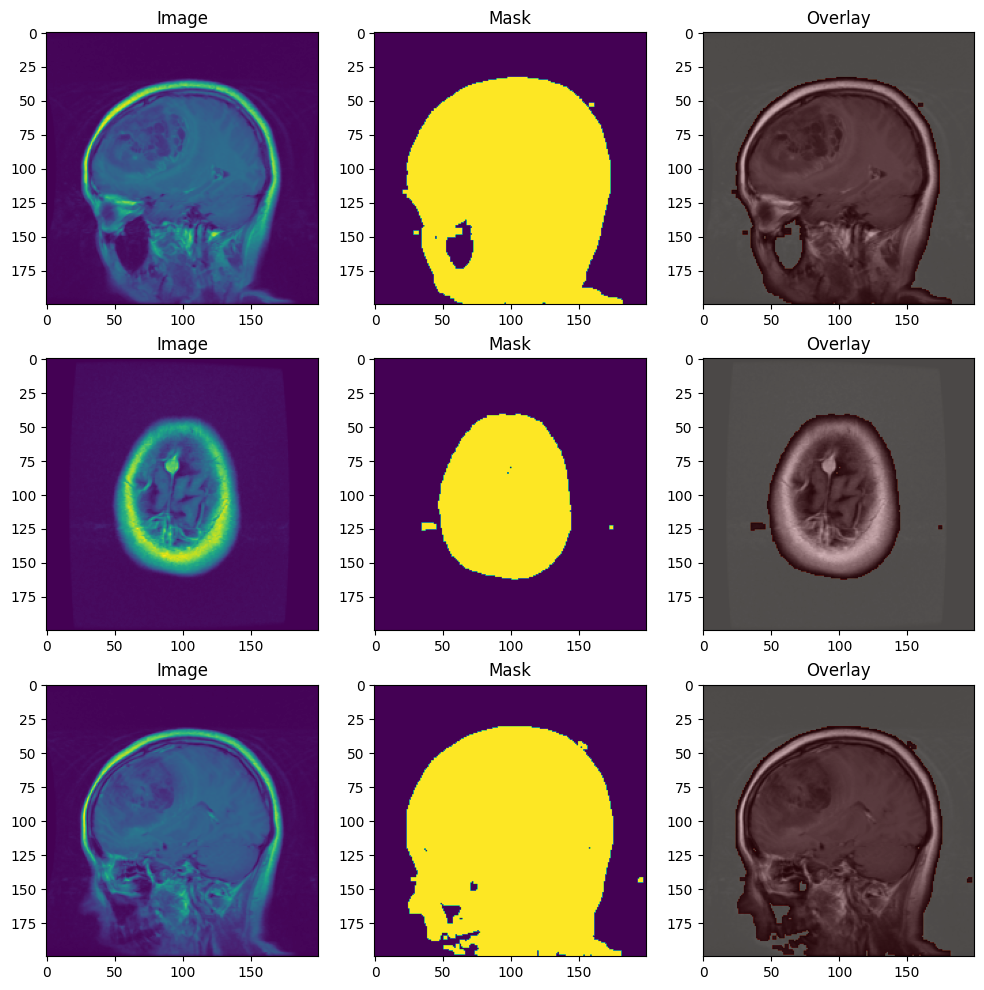

In [35]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# 검증 데이터셋 확인
plt.figure(figsize=(12,12))
for i in range(3):
  plt.subplot(3,3,1+3*i)
  plt.title('Image')
  plt.imshow(val_input_imgs[i])
  plt.subplot(3,3,2+3*i)
  plt.title('Mask')
  plt.imshow(val_targets[i])
  plt.subplot(3,3,3+3*i)
  plt.title('Overlay')
  plt.imshow(val_input_imgs[i], cmap='gray')
  plt.imshow(val_targets[i], cmap='Reds', alpha=0.3)

### 3.3. 모델 만들기

#### 3.3.1. 모델 학습 준비

In [36]:
class BrainDataset(Dataset):
    def __init__(self, img_list, resize=200):
        self.img_list = img_list
        self.resize = (resize, resize)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img_arr = skio.imread(img_path)

        # 이미지 전처리
        input_arr = skit.resize(img_arr, self.resize, anti_aliasing=True) # 이미지 크기 리사이징
        input_arr = np.expand_dims(np.array(input_arr), axis=0) # 이미지를 tensor로 변환
        input_arr = (input_arr - np.min(input_arr))/(np.max(input_arr)-np.min(input_arr)) # 이미지 정규화 (0~1)
        input_tensor = torch.tensor(input_arr, dtype=torch.float32)

        # 마스크 전처리
        output_arr = skim.closing(np.where(img_arr > 20,  1, 0)) # 레이블 형태(0,1)로 변환
        output_arr = skit.resize(output_arr, self.resize) # 이미지 크기 리사이징
        output_arr = np.expand_dims(np.array(output_arr), axis=0) # 마스크를 tensor로 변환
        output_arr = np.where(output_arr > 0, 1, 0) # 레이블 형태(0,1)로 변환
        output_tensor = torch.tensor(output_arr, dtype=torch.float32)

        # if self.transform:
        #     image = self.transform(image)

        return input_tensor, output_tensor

In [37]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
img_file_list = [os.path.join(img_fol_path, i) for i in sorted(os.listdir(img_fol_path))]
train_list = img_file_list[:-num_val_samples]
test_list = img_file_list[-num_val_samples:]
print(f'Train Number = {len(train_list)} / Validation Number = {len(test_list)}')

Train Number = 900 / Validation Number = 100


In [38]:
brain_train = BrainDataset(train_list)
brain_test = BrainDataset(test_list)

# 데이터셋 확인 (torch tensor)
print(brain_train.__len__())
print(brain_train.__getitem__(0)[0].size(), brain_train.__len__())
print(brain_test.__getitem__(0)[0].size(), brain_test.__len__())

900
torch.Size([1, 200, 200]) 900
torch.Size([1, 200, 200]) 100


torch.Size([1, 200, 200])
torch.Size([1, 200, 200])


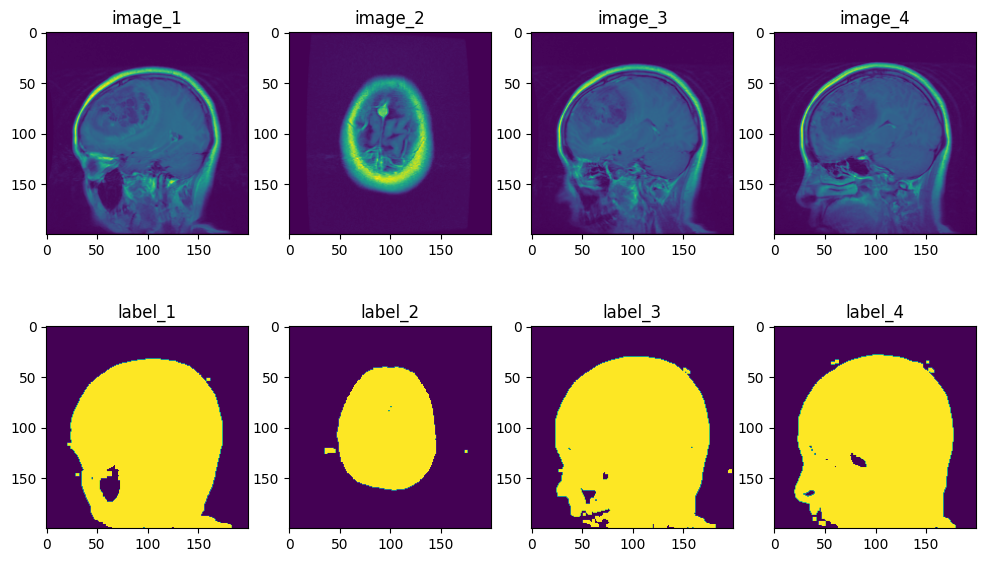

In [39]:
print(brain_test[0][0].size()) # 0번째 프레임의 이미지 크기 출력
print(brain_test[0][1].size()) # 0번째 프레임의 레이블 크기 출력
plt.figure(figsize=(12,7))
for i in range(4): # 4개의 데이터 추가 확인
    plt.subplot(2,4,i+1)
    plt.imshow(np.moveaxis(brain_test[i][0].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'image_{i+1}')
    plt.subplot(2,4,i+5)
    plt.imshow(np.moveaxis(brain_test[i][1].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'label_{i+1}')

torch.Size([1, 200, 200])
torch.Size([1, 200, 200])


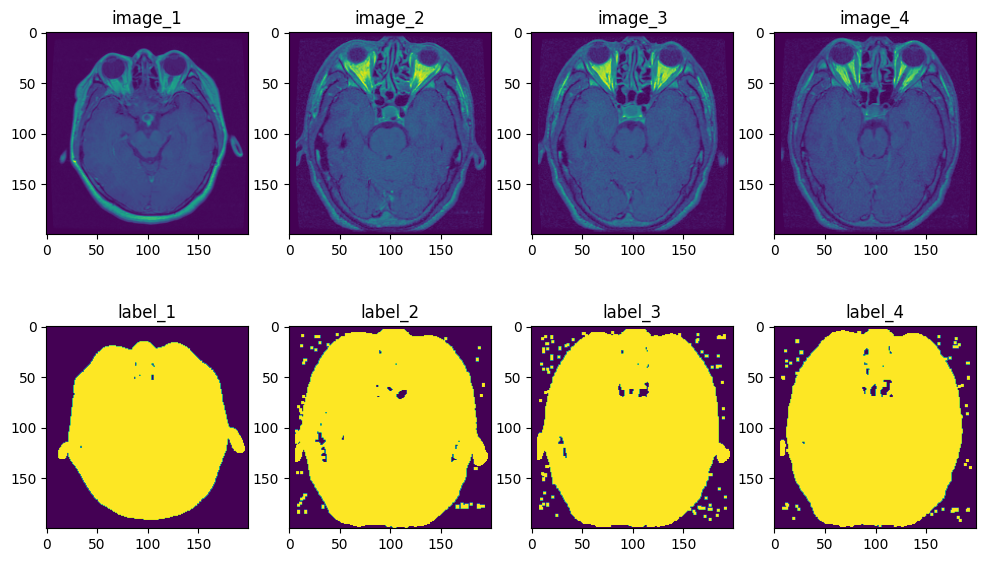

In [52]:
print(brain_test[0][0].size()) # 0번째 프레임의 이미지 크기 출력
print(brain_test[0][1].size()) # 0번째 프레임의 레이블 크기 출력
plt.figure(figsize=(12,7))
for i in range(4): # 4개의 데이터 추가 확인
    plt.subplot(2,4,i+1)
    plt.imshow(np.moveaxis(brain_test[i+50][0].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'image_{i+1}')
    plt.subplot(2,4,i+5)
    plt.imshow(np.moveaxis(brain_test[i+50][1].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'label_{i+1}')

In [40]:
batch_size = 8

train_loader = DataLoader(brain_train, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader = DataLoader(brain_test, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)

#### 3.3.2. 모델 빌드

In [41]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.output_layer(x)
        return x

In [42]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = FCN(1).to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.BCELoss() #nn.BCEWithLogitsLoss()

# 최적화함수로는 Adam을 사용합니다.
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [43]:
summary(model, (1, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]             640
              ReLU-2         [-1, 64, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          36,928
              ReLU-4         [-1, 64, 100, 100]               0
            Conv2d-5          [-1, 128, 50, 50]          73,856
              ReLU-6          [-1, 128, 50, 50]               0
            Conv2d-7          [-1, 128, 50, 50]         147,584
              ReLU-8          [-1, 128, 50, 50]               0
            Conv2d-9          [-1, 256, 25, 25]         295,168
             ReLU-10          [-1, 256, 25, 25]               0
           Conv2d-11          [-1, 256, 25, 25]         590,080
             ReLU-12          [-1, 256, 25, 25]               0
  ConvTranspose2d-13          [-1, 256, 25, 25]         590,080
             ReLU-14          [-1, 256,

### 3.4. 모델 학습

In [44]:
# 학습 모듈
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batches)
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Epoch result
        train_loss += loss.item()

        # Traing Process check
        loss, current = loss.item(), (batch + 1) * len(x)
        acc = 1 - loss
        pbar.set_description(f" - Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}, acc = {100*acc:>0.1f}%")
        pbar.update(1)
    pbar.close()
    # epoch
    train_loss /= num_batches
    train_acc = 1 - train_loss
    return train_loss, train_acc

In [45]:
# 검증 모듈
def test(dataloader, model, loss_fn, epoch, show=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    test_acc = 1 - test_loss
    if show:
        print(f"    = Validation[{epoch}]: val_loss = {test_loss:>5f}, val_acc: {(100*test_acc):>0.1f}%")
    return test_loss, test_acc

In [46]:
num_epoch = 10

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for t in range(num_epoch):
    train_loss, train_acc = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss, val_acc = test(test_loader, model, loss_func, t+1)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f'# Training[{t+1}/{num_epoch}]: loss = {train_loss:>5f}, acc = {100*train_acc:>0.1f}%, val_loss = {val_loss:5>f}, val_acc = {100*val_acc:>0.1f}%')

 - Batch Training[1](896/900): loss = 0.059273, acc = 94.1%: 100%|██████████| 112/112 [00:23<00:00,  4.80it/s]


# Training[1/10]: loss = 0.294169, acc = 70.6%, val_loss = 0.072907, val_acc = 92.7%


 - Batch Training[2](896/900): loss = 0.035202, acc = 96.5%: 100%|██████████| 112/112 [00:25<00:00,  4.38it/s]


# Training[2/10]: loss = 0.045349, acc = 95.5%, val_loss = 0.051563, val_acc = 94.8%


 - Batch Training[3](896/900): loss = 0.031968, acc = 96.8%: 100%|██████████| 112/112 [00:23<00:00,  4.78it/s]


# Training[3/10]: loss = 0.033888, acc = 96.6%, val_loss = 0.045233, val_acc = 95.5%


 - Batch Training[4](896/900): loss = 0.019425, acc = 98.1%: 100%|██████████| 112/112 [00:23<00:00,  4.80it/s]


# Training[4/10]: loss = 0.028968, acc = 97.1%, val_loss = 0.036543, val_acc = 96.3%


 - Batch Training[5](896/900): loss = 0.018181, acc = 98.2%: 100%|██████████| 112/112 [00:23<00:00,  4.83it/s]


# Training[5/10]: loss = 0.025492, acc = 97.5%, val_loss = 0.034329, val_acc = 96.6%


 - Batch Training[6](896/900): loss = 0.025075, acc = 97.5%: 100%|██████████| 112/112 [00:24<00:00,  4.62it/s]


# Training[6/10]: loss = 0.023847, acc = 97.6%, val_loss = 0.033598, val_acc = 96.6%


 - Batch Training[7](896/900): loss = 0.021168, acc = 97.9%: 100%|██████████| 112/112 [00:23<00:00,  4.80it/s]


# Training[7/10]: loss = 0.022258, acc = 97.8%, val_loss = 0.029894, val_acc = 97.0%


 - Batch Training[8](896/900): loss = 0.023666, acc = 97.6%: 100%|██████████| 112/112 [00:24<00:00,  4.61it/s]


# Training[8/10]: loss = 0.021166, acc = 97.9%, val_loss = 0.030124, val_acc = 97.0%


 - Batch Training[9](896/900): loss = 0.028763, acc = 97.1%: 100%|██████████| 112/112 [00:23<00:00,  4.76it/s]


# Training[9/10]: loss = 0.019798, acc = 98.0%, val_loss = 0.026931, val_acc = 97.3%


 - Batch Training[10](896/900): loss = 0.018432, acc = 98.2%: 100%|██████████| 112/112 [00:23<00:00,  4.77it/s]


# Training[10/10]: loss = 0.018854, acc = 98.1%, val_loss = 0.025913, val_acc = 97.4%


### 3.5. 결과 확인

In [47]:
for key in history.keys():
    print(key, history[key])

loss [0.29416941182820927, 0.045349307341634164, 0.033888106916232834, 0.028968041405148272, 0.02549222202339609, 0.023846636243563677, 0.022258348280696998, 0.021166456963068674, 0.01979752295717065, 0.01885369373485446]
val_loss [0.0729066791633765, 0.05156346162160238, 0.04523326766987642, 0.036543207398305334, 0.03432874707505107, 0.033598072516421475, 0.029894002558042605, 0.030124384444206953, 0.026931261954208214, 0.025912980549037457]
acc [0.7058305881717908, 0.9546506926583659, 0.9661118930837672, 0.9710319585948517, 0.9745077779766039, 0.9761533637564364, 0.977741651719303, 0.9788335430369314, 0.9802024770428294, 0.9811463062651455]
val_acc [0.9270933208366235, 0.9484365383783976, 0.9547667323301235, 0.9634567926016947, 0.9656712529249489, 0.9664019274835786, 0.9701059974419574, 0.969875615555793, 0.9730687380457917, 0.9740870194509625]


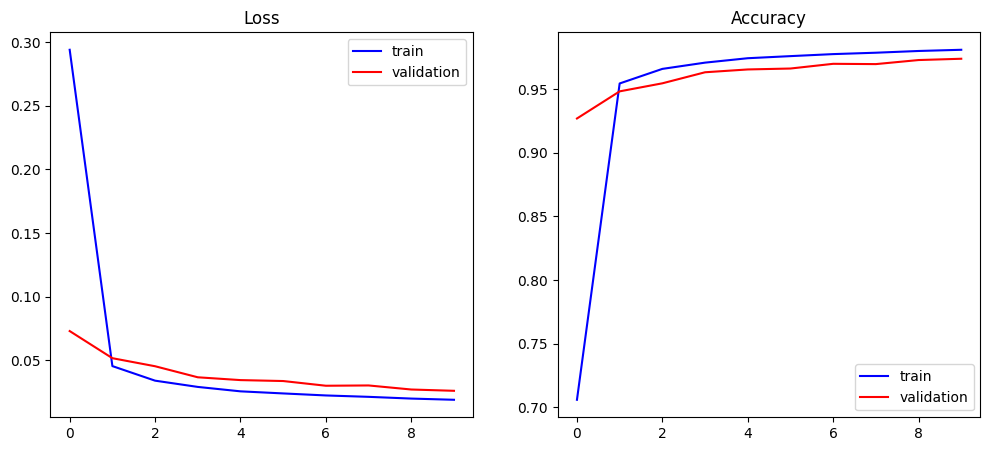

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], c='b', label='train')
plt.plot(history['val_loss'], c='r', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history['acc'], c='b', label='train')
plt.plot(history['val_acc'], c='r', label='validation')
plt.legend()

In [49]:
pred_list = []
with torch.no_grad():
    for img, lab in test_loader:
        x = img.to(device)
        pred = model.forward(x)
        for i in range(len(x)):
            probs = pred[i].cpu().detach().numpy()
            pred_list.append(probs)
print(pred_list[0].shape)
print(len(pred_list))

(1, 200, 200)
96


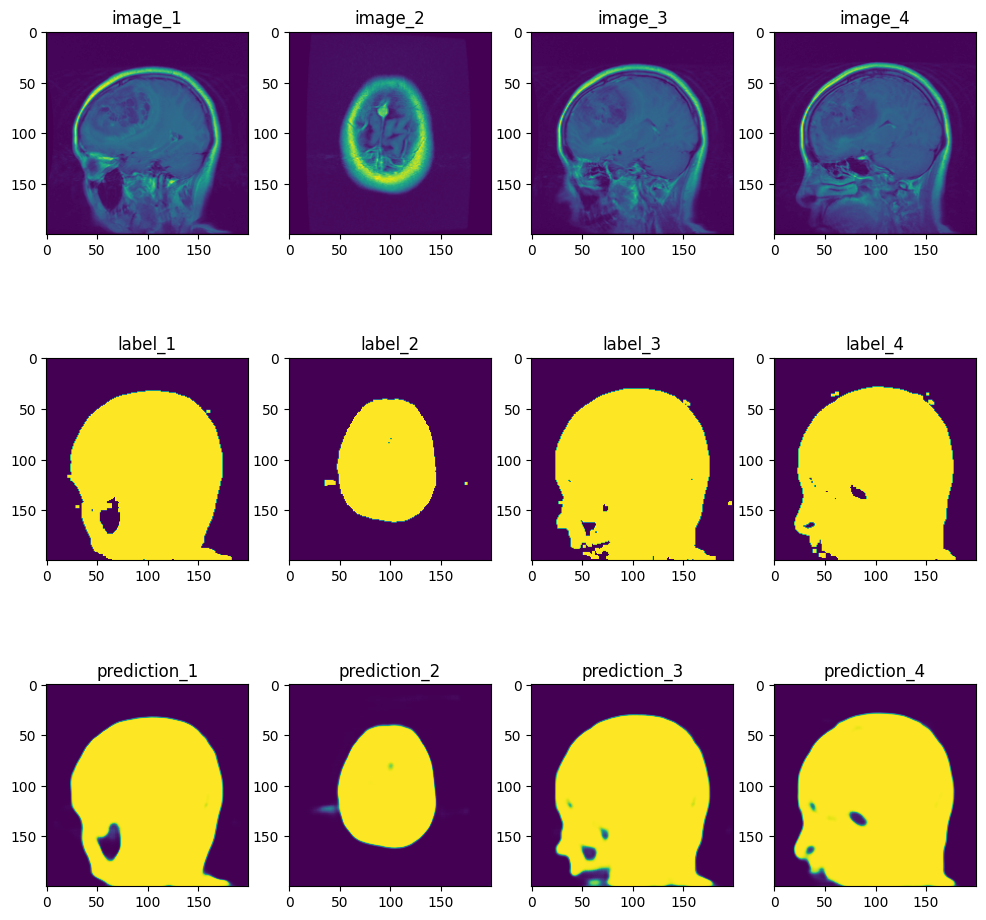

In [50]:
plt.figure(figsize=(12,12))
for i in range(4):
    img = np.moveaxis(brain_test[i][0].detach().numpy(), 0 , -1)
    label = np.moveaxis(brain_test[i][1].detach().numpy(), 0 , -1)
    pred = np.moveaxis(pred_list[i], 0 , -1)
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f'image_{i+1}')
    plt.subplot(3,4,i+5)
    plt.imshow(label)
    plt.title(f'label_{i+1}')
    plt.subplot(3,4,i+9)
    plt.imshow(pred)
    plt.title(f'prediction_{i+1}')

Text(0.5, 1.0, 'Comparison')

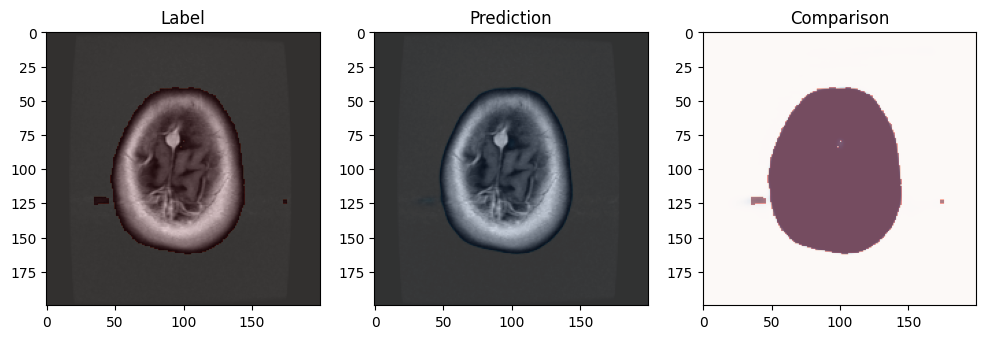

In [51]:
n = 1
img = np.moveaxis(brain_test[n][0].detach().numpy(), 0 , -1)
label = np.moveaxis(brain_test[n][1].detach().numpy(), 0 , -1)
pred = np.moveaxis(pred_list[n], 0 , -1)
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.imshow(label, cmap='Reds', alpha=0.2)
plt.title('Label')
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.imshow(pred, cmap='Blues', alpha=0.2)
plt.title('Prediction')
plt.subplot(133)
plt.imshow(pred, cmap='Blues', alpha=0.5)
plt.imshow(label, cmap='Reds', alpha=0.5)
plt.title('Comparison')

Text(0.5, 1.0, 'Comparison')

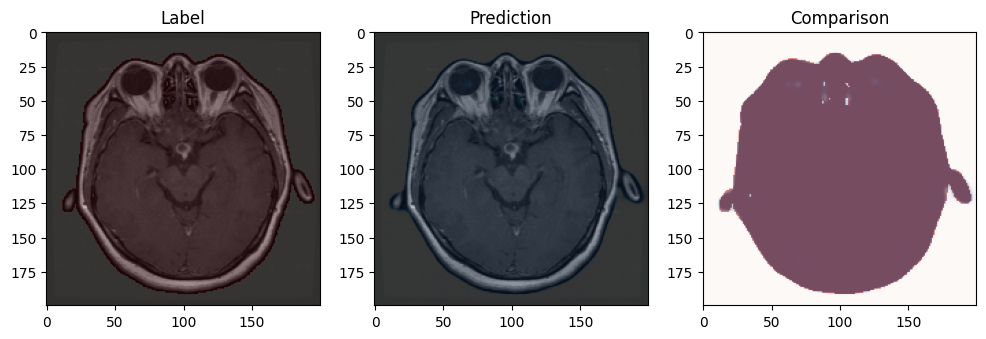

In [53]:
n = 50
img = np.moveaxis(brain_test[n][0].detach().numpy(), 0 , -1)
label = np.moveaxis(brain_test[n][1].detach().numpy(), 0 , -1)
pred = np.moveaxis(pred_list[n], 0 , -1)
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.imshow(label, cmap='Reds', alpha=0.2)
plt.title('Label')
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.imshow(pred, cmap='Blues', alpha=0.2)
plt.title('Prediction')
plt.subplot(133)
plt.imshow(pred, cmap='Blues', alpha=0.5)
plt.imshow(label, cmap='Reds', alpha=0.5)
plt.title('Comparison')